# Предсказание стоимости автомобиля по VIN-коду

---



## Полезные ссылки про VIN-код:

* https://en.wikibooks.org/wiki/Vehicle_Identification_Numbers_(VIN_codes)#Table_of_Contents
* https://en.wikibooks.org/wiki/Vehicle_Identification_Numbers_(VIN_codes)/World_Manufacturer_Identifier_(WMI)
* https://en.wikibooks.org/wiki/Vehicle_Identification_Numbers_(VIN_codes)/Printable_version#Model#
* https://en.wikipedia.org/wiki/List_of_Ford_factories

## Из чего состоит VIN-код

VIN-код (Vehicle Identification Number) — это уникальный идентификационный номер, который присваивается каждому автомобилю при его производстве и используется для идентификации автомобилей при покупке, регистрации, страховании, а также при проведении технического обслуживания и ремонта.

***Он состоит из 17 символов:***

* **1-3 производитель**
* **4 ремни безопасности для пассажирских, тормоза и грузоподъемность у траков**
* **5-7 модель**
* **8 двигатель**
* **9 контрольный знак**
* **10 год**
* **11 завод-производитель**
* **12-17 серийный номер**


Цель данной работы, используя "сырые" данные, построить модель, которая по VIN-коду сможет предсказать стоимость машины.

In [1]:
!pip install category_encoders

In [2]:
# Импорт библиотек

import category_encoders as ce
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns
import warnings

from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import (GridSearchCV ,cross_val_score ,train_test_split)
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

warnings.filterwarnings('ignore')

## Работа с регулярными выражениями

In [3]:
# создаем список символов, допустимых для использования в VIN-кодах автомобилей
ALLOWED_CHARS = [chr(x) for x in range(ord('A'), ord('Z')+1) if chr(x) not in ('I', 'O', 'Q')]
ALLOWED_NUMS = [str(x) for x in range(1,10)] + ['0']

allowed = ''.join(ALLOWED_CHARS+ALLOWED_NUMS)
allowed

'ABCDEFGHJKLMNPRSTUVWXYZ1234567890'

In [4]:
# строим регулярные выражения для различных частей VIN-кода автомобиля, а также для цены
WMI_RE = f'(?P<wmi>[{allowed}]{{3}})'
RESTRAINT_RE = f'(?P<restraint>[{allowed}])'
MODEL_RE = f'(?P<model>[{allowed}]{{3}})'
ENGINE_RE = f'(?P<engine>[{allowed}])'
CHECK_RE = f'(?P<check>[{allowed}])'
YEAR_RE = f'(?P<year>[{allowed.replace("U", "").replace("Z", "")}])'
PLANT_RE = f'(?P<plant>[{allowed}])'
VIS_RE = f'(?P<vis>[{allowed}]{{3}}\\d{{3}})'

In [5]:
VIN_RE = f'{WMI_RE}{RESTRAINT_RE}{MODEL_RE}{ENGINE_RE}{CHECK_RE}{YEAR_RE}{PLANT_RE}{VIS_RE}'
PRICE_RE = r'(?P<price>\d+)'

In [6]:
# Открытие файла и чтение содержимого
file_path = '/content/drive/MyDrive/vin_ford_train.txt'
with open(file_path, 'r') as file:
    data = file.read()

data[:500]

'[2FMDK3JC4BBA41556:12500]мой[3FA6P0H75ER208976:14500]дядя [3FAHP08Z17R268380:1300][1FMCU0GX3DUC59421:15200]самых [1FAHP2E89DG119368:11600] верных[1FM5K8D82DGA16143:26400][1FTFW1CFXCFC23663:14000][2FMDK3JC6CBA90002:19500][1FTFW1CT8DKD06233:24400][1FMZU64W13UC28949:2900][2FMDK3JC9DBB30736:23500][1FMCU9D76CKC49193:12700][1FMCU9EG2CKA90624:20700][1FMCU0JX7EUA28208:21300][2FMGK5D85EBD31213:26700][2FMDK4KC6EBA72011:25100]правил [1FTFX1EF2EKE24350:26700][1ZVBP8EM0D5237253:11600][1FDNE1BW5BDA64735:13200'

In [7]:
# создаем регулярное выражение, которое используется для поиска VIN-кодов и соответствующих им цен в тексте
data_re = re.compile(f'\\[{VIN_RE}:{PRICE_RE}\\]')
data_re

re.compile(r'\[(?P<wmi>[ABCDEFGHJKLMNPRSTUVWXYZ1234567890]{3})(?P<restraint>[ABCDEFGHJKLMNPRSTUVWXYZ1234567890])(?P<model>[ABCDEFGHJKLMNPRSTUVWXYZ1234567890]{3})(?P<engine>[ABCDEFGHJKLMNPRSTUVWXYZ1234567890])(?P<check>[ABCDEFGHJKLMNPRSTUVWXYZ1234567890])(?P<year>[ABCDEFGHJKLMNPRSTVWXY1234567890])(?P<plant>[ABCDEFGHJKLMNPRSTUVWXYZ1234567890])(?P<vis>[ABCDEFGHJKLMNPRSTUVWXYZ1234567890]{3}\d{3}):(?P<price>\d+)\]',
re.UNICODE)

In [8]:
# просмотр структуры данных
values = []
for obj in data_re.finditer(data):
  values.append(obj.groupdict())

values[:1]

[{'wmi': '2FM',
  'restraint': 'D',
  'model': 'K3J',
  'engine': 'C',
  'check': '4',
  'year': 'B',
  'plant': 'B',
  'vis': 'A41556',
  'price': '12500'}]

In [9]:
# поиск невалидных объектов
valid_vin = r'(\w{14}\d{3})'
valid_price = r'(\d+)'

invalid_vin = r'(?!\w{14}\d{3})(\w+)'
invalid_price = r'(?!\d+)(\w+)'

invalid_variance = [
    f'\\[{invalid_vin}:{invalid_price}\\]',
    f'\\[{valid_vin}:{invalid_price}\\]',
    f'\\[{invalid_vin}:{valid_price}\\]',
]

invalid_pattern = re.compile('(?P<invalid_data>' + '|'.join(invalid_variance) + ')')

invalid_values = []

for obj in invalid_pattern.finditer(data):
    invalid_values.append(obj.groupdict())

invalid_values

[{'invalid_data': '[1FM5K8D83DGB91002:XXXX]'},
 {'invalid_data': '[1FM5K8D83DGB9100X:26600]'}]

## Создание и изучение датафрейма

In [10]:
df = pd.DataFrame(values)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71884 entries, 0 to 71883
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   wmi        71884 non-null  object
 1   restraint  71884 non-null  object
 2   model      71884 non-null  object
 3   engine     71884 non-null  object
 4   check      71884 non-null  object
 5   year       71884 non-null  object
 6   plant      71884 non-null  object
 7   vis        71884 non-null  object
 8   price      71884 non-null  object
dtypes: object(9)
memory usage: 4.9+ MB


In [11]:
# преобразуем цену в число
df['price'] = df['price'].astype(int)

In [12]:
df.head()

,wmi,restraint,model,engine,check,year,plant,vis,price
0,2FM,D,K3J,C,4,B,B,A41556,12500
1,3FA,6,P0H,7,5,E,R,208976,14500
2,3FA,H,P08,Z,1,7,R,268380,1300
3,1FM,C,U0G,X,3,D,U,C59421,15200
4,1FA,H,P2E,8,9,D,G,119368,11600


In [13]:
# Проверяем наличие дубликатов в DataFrame
print("Дубликаты в DataFrame:", df.duplicated().sum())

Дубликаты в DataFrame: 0


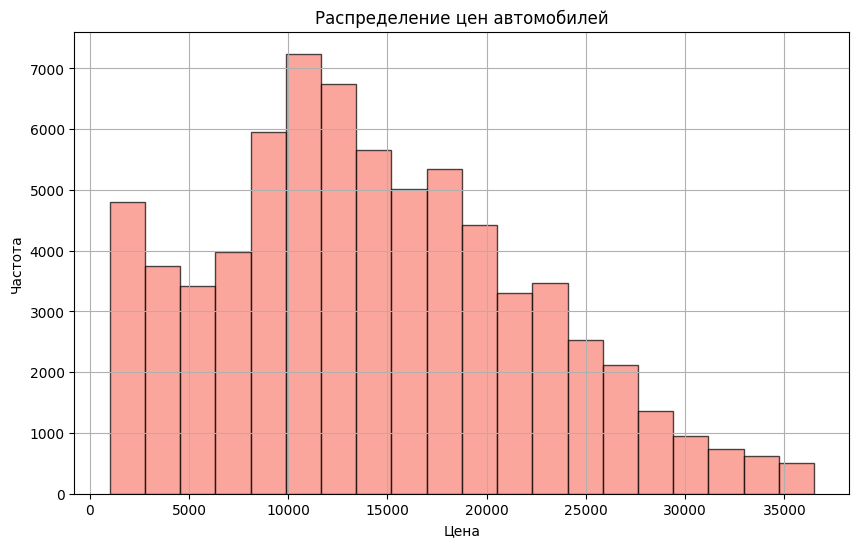

In [14]:
# Построение гистограммы с заданными параметрами
plt.figure(figsize=(10, 6))
df.price.hist(bins=20, color='salmon', edgecolor='black', alpha=0.7)
plt.title('Распределение цен автомобилей')
plt.xlabel('Цена')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

Из графика можно сделать вывод, что большинство автомобилей имеет цену от 7000 до 20000. В целом распределение выглядит нормальным, без резких аномалий

## Подготовка к обучению

In [15]:
features = df.drop(['price'], axis=1)
target = df['price']


In [16]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=42)

print(features_train.shape)
print(features_test.shape)
print(target_train.shape)
print(target_test.shape)

(53913, 8)
(17971, 8)
(53913,)
(17971,)


In [17]:
# Кодирование категориальных признаков OrdinalEncoder

categorical_features = ['wmi', 'restraint', 'model', 'engine', 'check', 'year', 'plant', 'vis']

# Создание кодировщика
encoder = ce.OrdinalEncoder(cols=categorical_features)

# Применение кодировщика к обучающим и тестовым данным
features_train_encoded = encoder.fit_transform(features_train[categorical_features])
features_test_encoded = encoder.transform(features_test[categorical_features])

# Вывод первых строк закодированных данных
print(features_train_encoded.head())
print(features_test_encoded.head())

       wmi  restraint  model  engine  check  year  plant  vis
25893    1          1      1       1      1     1      1    1
65422    2          2      2       2      2     2      2    2
41499    3          3      3       3      2     3      3    3
2148     3          4      4       4      3     4      4    4
6583     3          4      4       5      2     5      4    5
       wmi  restraint  model  engine  check  year  plant  vis
19770    6          7   60.0      20     10   1.0     13 -1.0
57555    6         14   53.0       8      3   3.0     13 -1.0
62950    4          2  164.0      26      2   2.0      5 -1.0
38093    3          7   52.0       8      9  15.0     12 -1.0
69373    3          3  128.0       3      2   3.0      3 -1.0


## Обучение и проверка модели

In [18]:
# Пример модели случайного леса

model_forest = RandomForestRegressor(random_state=42)
parameter = {'max_depth':range(10, 50, 10),
              'n_estimators': range(2,10,2)}

gs_forest = GridSearchCV(model_forest, parameter, cv=3, scoring='neg_root_mean_squared_error', n_jobs=1, verbose=1)

gs_forest.fit(features_train_encoded, target_train)

# Оценка производительности модели случайного леса на тестовом наборе данных
score_rf = gs_forest.score(features_test_encoded, target_test)
print("Средняя квадратичная ошибка модели случайного леса на тестовом наборе данных:", abs(score_rf))

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Средняя квадратичная ошибка модели случайного леса на тестовом наборе данных: 3346.646172165786


In [19]:
# Создание дамми модели
dummy_model = DummyRegressor(strategy="mean")

# Обучение дамми модели
dummy_model.fit(features_train_encoded, target_train)

# Предсказание с помощью дамми модели
y_pred_dummy = dummy_model.predict(features_test_encoded)

# Оценка производительности дамми модели
dummy_mse = mean_squared_error(target_test, y_pred_dummy)
print("Средняя квадратичная ошибка дамми модели:", dummy_mse**0.5)

Средняя квадратичная ошибка дамми модели: 7839.305589736664


Модель случайного леса ошибается гораздо меньше, чем дамми-модель, значит модель хорошая

## Важность признаков и корреляция

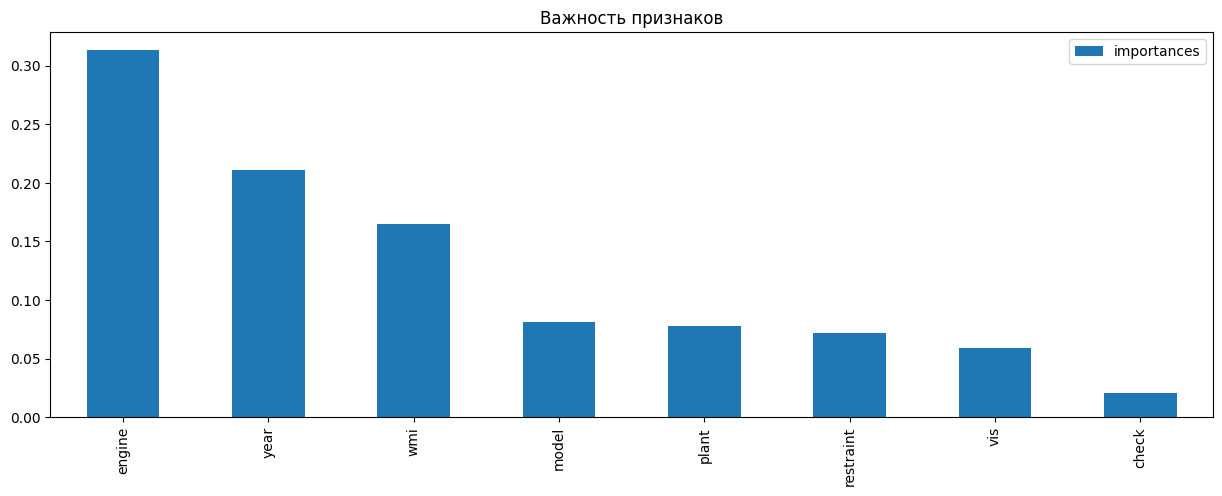

In [20]:
# рассмотрим важность признаков при обучении модели случайного леса
importances = pd.DataFrame(gs_forest.best_estimator_.feature_importances_,
                           index = features_test_encoded.columns, columns=['importances'])
importances = importances.sort_values(by='importances', ascending=False)
importances

importances.plot(kind='bar', figsize=(15, 5), title='Важность признаков')
plt.show();

Признаками, которые наиболее влияют на цену, являются двигатель, год производства и производитель. Контрольный знак - check, влияет меньше всего

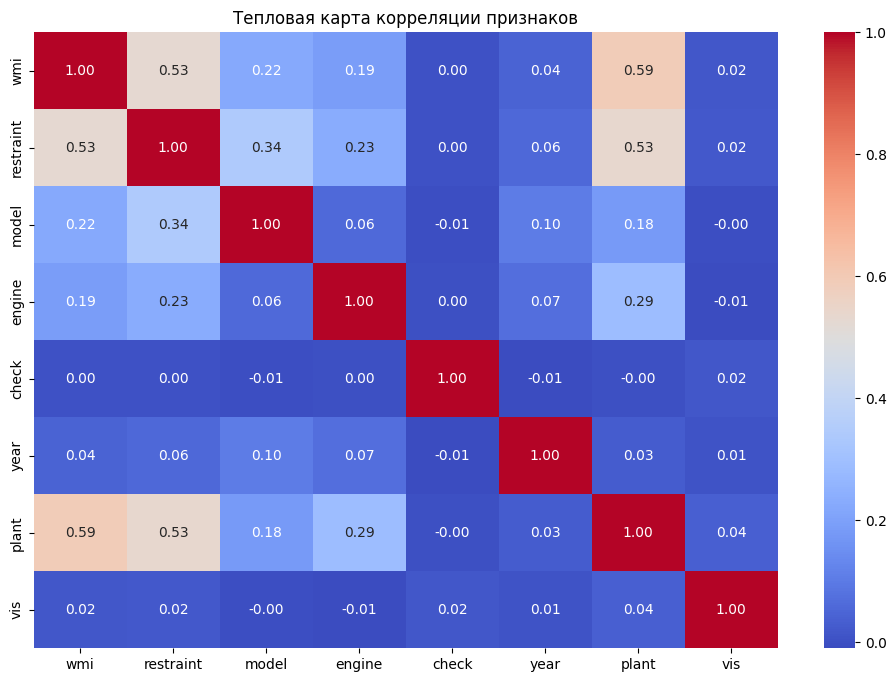

In [21]:
# Вычисление матрицы корреляции
correlation_matrix = features_test_encoded.corr()

# Построение тепловой карты корреляции
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Тепловая карта корреляции признаков')
plt.show()

Самая высокая корреляция обнаружена у признаков - производитель и завод изготовитель. Возможно, если убрать признак plant, модель будель показывать еще более лучший результат, но это требует дополнительного исследования и в рамках данного проекта, такой задачи не стоит

## Применение

In [22]:
# функция предсказания цены
def predict_prices(vin_codes):
    # Создаем список для хранения предсказанных цен
    predicted_prices = []

    # Проходимся по каждому VIN коду в списке
    for vin_code in vin_codes:
        # Разбиваем VIN код на соответствующие части
        wmi = vin_code[:3]
        restraint = vin_code[3]
        model = vin_code[4:7]
        engine = vin_code[7]
        check = vin_code[8]
        year = vin_code[9]
        plant = vin_code[10]
        vis = vin_code[11:]

        # Преобразуем части VIN кода в признаки
        vin_data = pd.DataFrame([{'wmi': wmi, 'restraint': restraint, 'model': model, 'engine': engine, 'check': check, 'year': year, 'plant': plant, 'vis': vis}])
        features_encoded = encoder.transform(vin_data)

        # Предсказание цены с использованием модели и добавление в список
        predicted_price = gs_forest.predict(features_encoded)
        predicted_prices.append(predicted_price[0])

    # Создаем DataFrame с результатами
    result_df = pd.DataFrame({'VIN Code': vin_codes, 'Predicted Price': predicted_prices})

    return result_df


In [23]:
# Пример использования функции для предсказания стоимости автомобилей по списку VIN кодов
vin_codes = ['1FMCU9EG2CKA90624', '2FMDK4KC6EBA72011', '1FTFW1CFXCFC23663', '1FAHP2E89DG119368']
predicted_prices_df = predict_prices(vin_codes)
print(predicted_prices_df)

            VIN Code  Predicted Price
0  1FMCU9EG2CKA90624     19452.571469
1  2FMDK4KC6EBA72011     26375.243056
2  1FTFW1CFXCFC23663     27098.822832
3  1FAHP2E89DG119368     11237.500000


## Вывод

В ходе работы над проектом:
* были изучили примеры данных, включая VIN-коды и цены автомобилей.
* был использован метод кодирования категориальных признаков для подготовки данных перед обучением модели. Это позволило использовать эти признаки в моделировании.
* была применена модель случайного леса для предсказания цен автомобилей на основе признаков, извлеченных из VIN-кодов. Был использован метод перекрестной проверки для выбора оптимальных параметров модели.
* была создана функцию, которая принимает VIN-код(ы) в качестве входных данных и возвращает предсказанную цену автомобиля.

Полученную модель можно улучшить, добавив больше данных или использовав другие методы машинного обучения. Также можно дополнительно извлечь признаки из VIN-кодов для улучшения точности предсказаний.

Результат работы: была создана работающая модель для предсказания цен автомобилей на основе их VIN-кодов, что может быть полезным для автомобильной индустрии и потребителей.